SpectralCube with shape=(1917, 350, 350) and unit=Jy / beam:
 n_x:    350  type_x: RA---SIN  unit_x: deg    range:   266.572768 deg:  266.603687 deg
 n_y:    350  type_y: DEC--SIN  unit_y: deg    range:   -28.608270 deg:  -28.581126 deg
 n_s:   1917  type_s: FREQ      unit_s: Hz     range: 115154357093.000 Hz:115388262765.053 Hz
SpectralCube with shape=(1, 350, 350) and unit=K:
 n_x:    350  type_x: RA---SIN  unit_x: deg    range:   266.572768 deg:  266.603687 deg
 n_y:    350  type_y: DEC--SIN  unit_y: deg    range:   -28.608270 deg:  -28.581126 deg
 n_s:      1  type_s: VRAD      unit_s: km / s  range:     -200.306 km / s:    -200.306 km / s


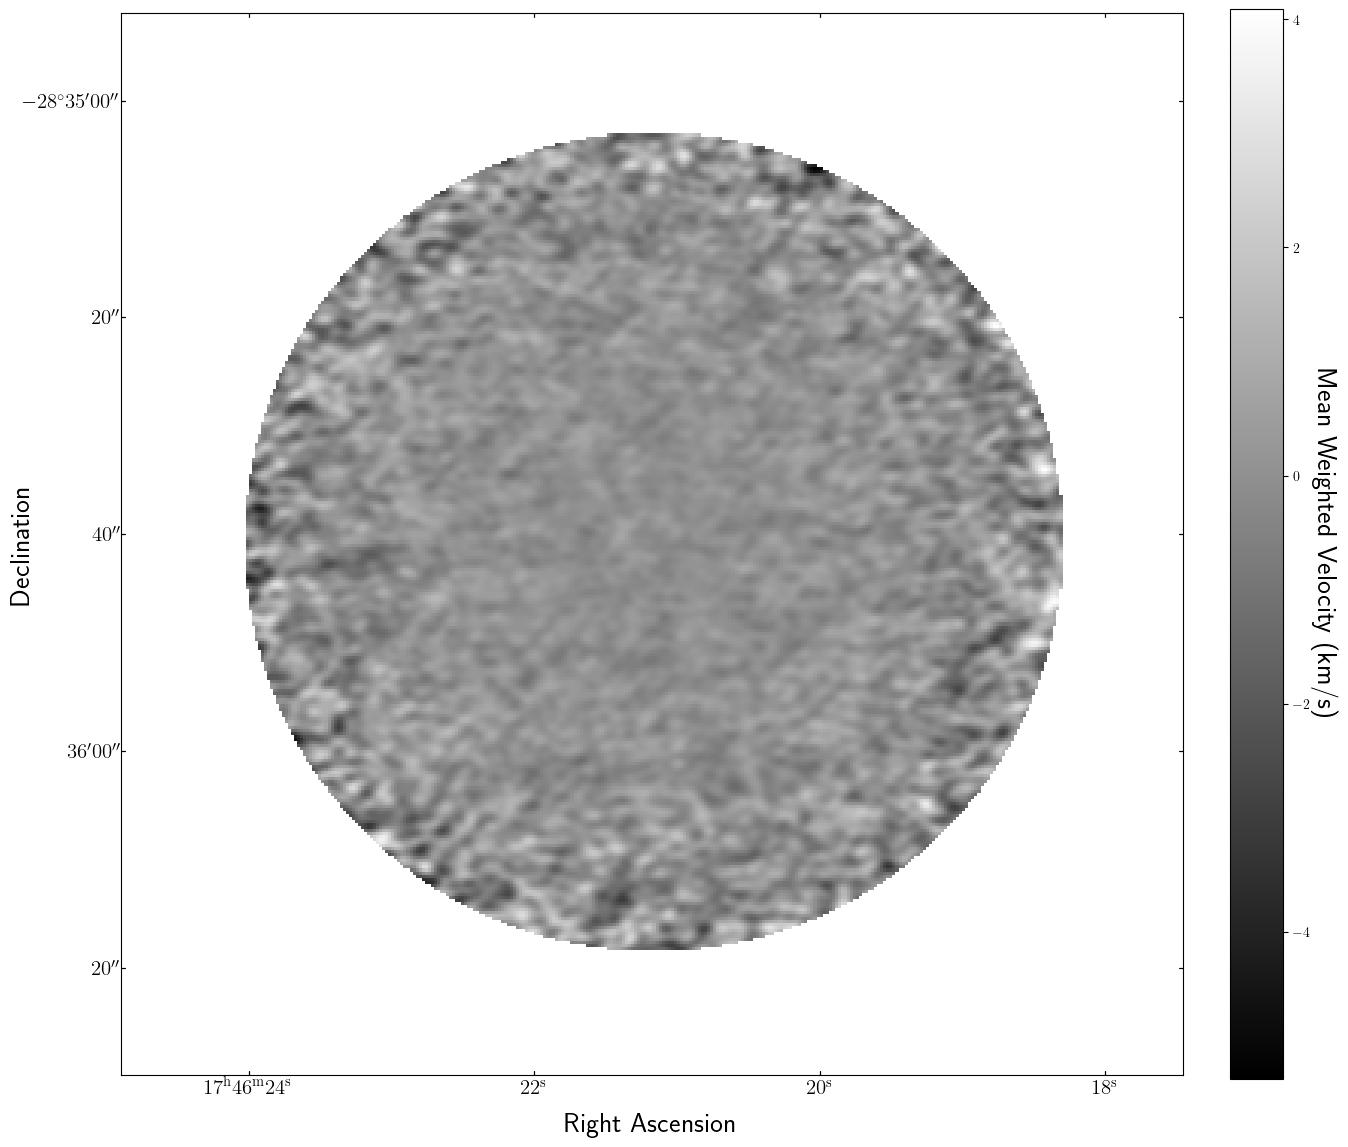

In [5]:
import numpy as np                          # I use this for maths and sometimes arrays.
import pylab                                # I use this for arrays and plotting
import matplotlib                           # Another plotting package
import matplotlib.gridspec as gridspec      # If there is a task you use a lot, importing it like this 
import scipy
import astropy.io.fits as fits              # I use this to import FITS images. 
from astropy.wcs import WCS                 # This one helps us add coordinates to images
from astropy import units as u              # This one helps with unit conversion
import regions
import pyspeckit as psk                     # I use this to do spectral line fitting
from spectral_cube import SpectralCube      # This is a handy package for working with 3D data cubes
import sys
if not sys.warnoptions:
    import warnings
    warnings.simplefilter("ignore")
%matplotlib inline                             
matplotlib.rc('font', family='sans-serif')  # Set plot fonts
matplotlib.rc('text', usetex=True)      
#matplotlib.rc('text', usetex=False)        # This is a quick fix if you don't have latex on your computer
fig1 = pylab.figure(1,figsize=(15,15))
sc = SpectralCube.read("B.Dust_Ridge_12C16O_1-0.cube.I.pbcor.fits")

sc_kms = sc.with_spectral_unit(u.km/u.s,velocity_convention="radio") # change from frequency to velocity
sc_slab = sc_kms.spectral_slab(-200. *u.km / u.s, -200. *u.km / u.s)  # Extract a subset of the velocities
sc_slab.allow_huge_operations=True
sc_bin = sc_slab.downsample_axis(3,axis=0)
print(sc)
sc_K_kms = sc_bin.to(u.K)               # Change intensity unit from Jy/beam to K
moment_1  = sc_K_kms.moment(order=0,how='slice') 
print(sc_K_kms)
ax1 = pylab.subplot(projection=moment_1.wcs) 
im1 = pylab.imshow(moment_1.hdu.data,cmap='grey')
RA = ax1.coords[0]                                                                  
Dec = ax1.coords[1]
RA.set_ticks(size=-3)                                                                                      
Dec.set_ticks(size=-3)                                                                                    
pylab.xlabel('Right Ascension',fontsize=20,labelpad=1)                               
pylab.ylabel('Declination',fontsize=20,labelpad=0)
ax1.tick_params(axis = 'both', which = 'major', labelsize = 15)    
cb=pylab.colorbar(im1,fraction=0.046,pad=0.04)                                      
cb.set_label(label='Mean Weighted Velocity (km/s)',fontsize=20,rotation=270,labelpad=20) 
cb.ax.tick_params(which = 'major', labelsize = 10)   
pylab.savefig("moment0.png")
#pylab.annotate(s='Moment 1',fontsize=35,xy=(0.02,0.91),xycoords="axes fraction")

64


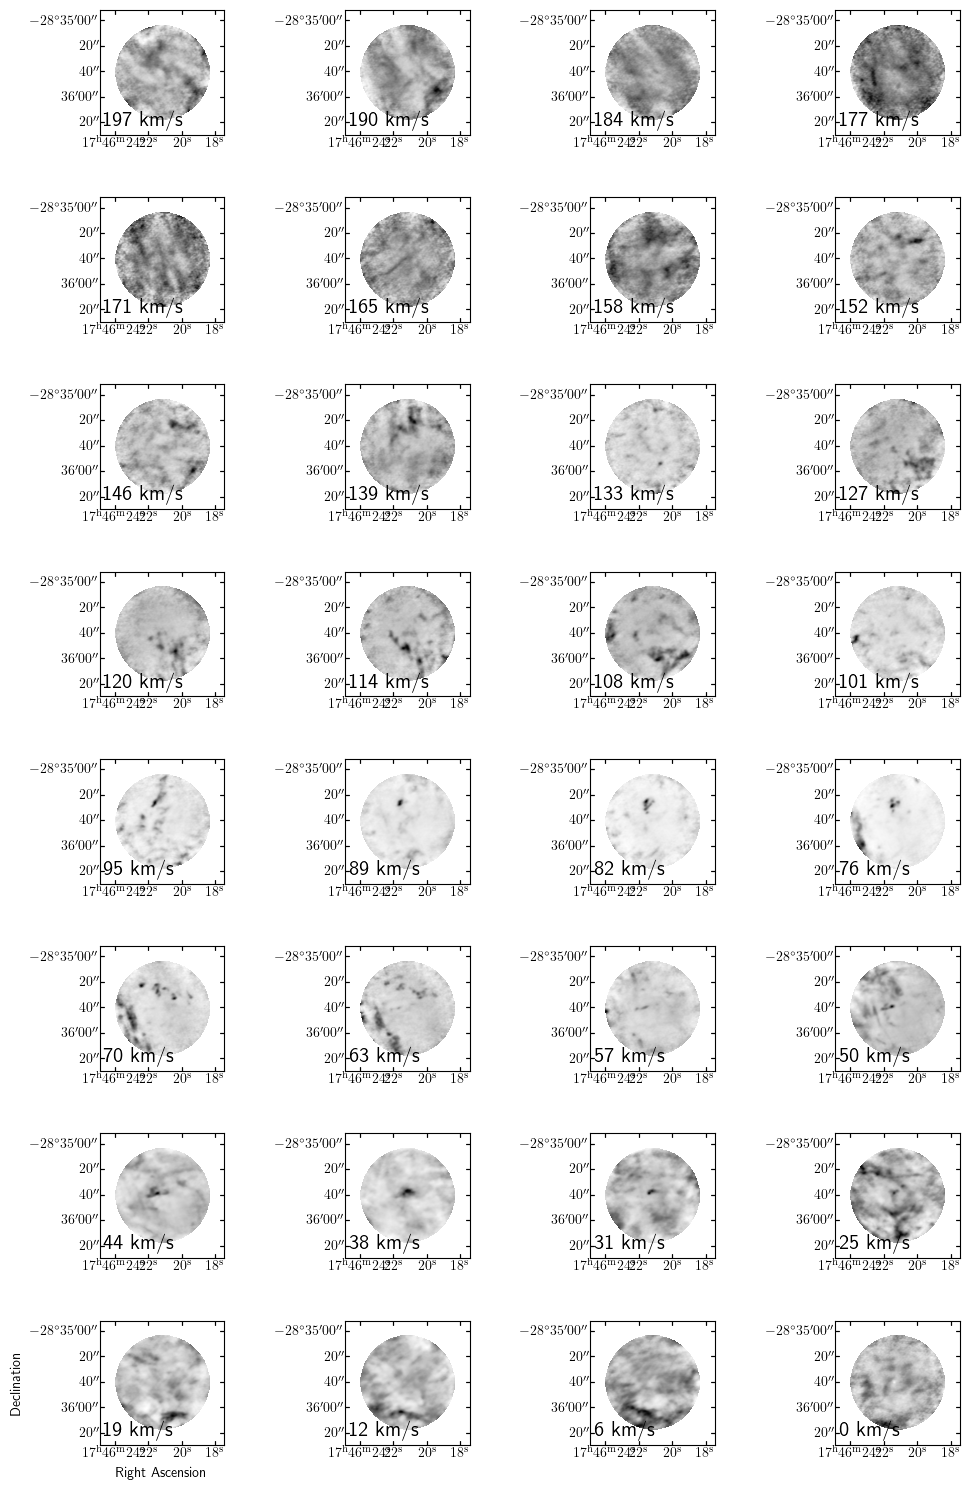

In [3]:
# In addition to moment maps, there are several other ways to extract 2D information from a data cube.
# The most common are channel maps and PV (position-velocity) diagrams.

# Example 1: Channel Maps (using the 12CO read in from the previous cell)
sc = SpectralCube.read("B.Dust_Ridge_12C16O_1-0.cube.I.pbcor.fits")

sc_kms = sc.with_spectral_unit(u.km/u.s,velocity_convention="radio") # change from frequency to velocity
sc_slab = sc_kms.spectral_slab(-200. *u.km / u.s, 200. *u.km / u.s)  # Extract a subset of the velocities
sc_slab.allow_huge_operations=True
sc_bin = sc_slab.downsample_axis(20,axis=0)


vel, dec, ra = sc_bin.world[:,0,0]           # For plotting purposes, I want to know the average velocity
# for each of these new averaged channels
moment_1  = sc_kms.moment(order=0,how='slice') 
fig1 = pylab.figure(1,figsize=(10,15))

print(len(sc_bin.hdu.data))                                            
for i in np.arange(0,32):                       # Now we loop through each slice (averaged channels) 
    ax = pylab.subplot(8,4,i+1,projection=moment_1.wcs) # We plot them in a grid
    im = pylab.imshow(sc_bin.hdu.data[i],cmap='Greys')
    RA = ax.coords[0]                                                                  
    Dec = ax.coords[1]
    RA.set_ticks(size=-3)                                                                                      
    Dec.set_ticks(size=-3)  
    pylab.text(10,25,s="%i km/s"%(vel.value[i]),fontsize=15) # Print the velocity of each averaged channel
    if i==28:
        pylab.xlabel("Right Ascension")
        pylab.ylabel("Declination")
    else:
        pylab.xlabel(" ")
        pylab.ylabel(" ") 
        
pylab.tight_layout(w_pad=1,h_pad=2)
pylab.savefig("PV.pdf")
pylab.savefig("PV.png")


In [ ]:
# Example 2: PV Diagrams
# Here we try to examine the velocity structure of an image by making a 2D plot of position vs. velocity
# We reduce the data to 2D by either averaging along one of the position axes (RA or Dec)
# or in this case, just choosing a single "slice" from the Declination axis

Dec_slice = 180                             # Pick a pixel along the Declination dimension to slice along

                                    
fig = pylab.figure(figsize=(7, 10))         # Initiate a figure and axis object with WCS projection information

                                            # Here we have specified to plot the longitude along the x axis
                                            # We also plot only the Declination slice we have chosen, 
                                            # and plot the velocity along the y axis
print(1)
ax = pylab.subplot(projection=sc_slab.wcs, slices=('x', Dec_slice, 'y'))
RA = ax.coords[0]
Dec = ax.coords[1]
velo = ax.coords[2]
print(2)
im = ax.imshow(sc_slab[:,Dec_slice, :].data)  # Display the image slice 
ax.set_aspect(aspect=0.25)

print(3)                                            # Add axes labels
ax.set_ylabel("LSR Velocity (m/s)", fontsize=16)
ax.set_xlabel("Right Ascension", fontsize=16)
velo.set_ticks(size=-2)                                                                                      
RA.set_ticks(size=-2)
print(4)                            
Dec.set_ticks_visible(False)                # Don't show a "Declination" axis because we have eliminated it
Dec.set_ticklabel_visible(False) 
print(5)
                                            # Do add a colorbar
cbar = pylab.colorbar(im, pad=.07, orientation='horizontal')
cbar.set_label('Brightness Temperature (K)', size=16)

1
